In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from transformers import TrOCRProcessor,VisionEncoderDecoderModel,Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
from torchvision import transforms
from datasets import load_metric
from torch.cuda import is_available as cuda_available
from torchvision.transforms import ToTensor
from FT_TrORC_utils import *
from TrORC_initiator import configure_model, load_model_with_check

c:\Users\Mert\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Mert\anaconda3\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
c:\Users\Mert\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Belirtilen yordam bulunamadı'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
#Reading the training and testing data
train_df = pd.read_csv('../data/processed/MMF_HAR_comb_processed/training/mmf_har_train_combined.csv')
test_df = pd.read_csv('../data/processed/MMF_HAR_comb_processed/testing/mmf_har_test_combined.csv')

print(train_df.head())
print(test_df.head())
print(train_df.columns)
print(test_df.columns)

         image                                               text
0  X2dmDrp.png  `` Chelsea Clinton steps out of college and he...
1  rOvVkF1.png  o 28 % 1:19 PM 76 AT & T M-Cell Details Dad Me...
2  m4oY5vK.png  On 1-20-2017 What is the first thing you want ...
3  Okb6dJB.png  N Dallas , Texas 10:31 AM CT DALLAS TRUMP VS ....
4  4KXGjz0.png  `` One thing ca n't stand is the military . It...
         image                                               text
0  12XLnzK.png  thewrap.com SUICIDE `` Suicide Squad ' Executi...
1  VAJZJJV.png  3 hrs This was in my Facebook feed this mornin...
2  zvdzU3y.png  Bernie or Hillary ? Be informed . Compare them...
3  qi0bYgG.png  WE 'RE FUCKED , MOVE TO CANADA I STILL FEEL YO...
4  NpsCjMn.png  SAYS BERNIE SANDERS SUPPORTERS ARE LAZY AND UN...
Index(['image', 'text'], dtype='object')
Index(['image', 'text'], dtype='object')


Convert text caption to token IDs using the model's tokenizer:

```python
# Input text: "Hello World"
input_ids = [101, 19082, 1362, 102, 0]
# Breakdown: [CLS] Hello World [SEP] [PAD]
```
Replace padding tokens with `-100` for loss masking

```python
labels = [101, 19882, 1362, 102, -100]
```

Model ignores the last element **during training** as the model learns to predict the last token

In [3]:
# Define the processor and model
# Load the TrOCR processor and model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

train_dataset = MMF_HAR(root_dir='../data/processed/MMF_HAR_comb_processed/images/training/',
                           df=train_df,
                           processor=processor)
eval_dataset = MMF_HAR(root_dir='../data/processed/MMF_HAR_comb_processed/images/testing/',
                           df=test_df,
                           processor=processor)

c:\Users\Mert\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3429
Number of validation examples: 858


Let's verify an **example** from the training dataset:

###################################################
pixel_values torch.Size([3, 384, 384])
labels torch.Size([32])
###################################################
Decoded label text : `` Chelsea Clinton steps out of college and her parents get her a job paying $ 900,000.00 per year. Now her mom goes around the
###################################################


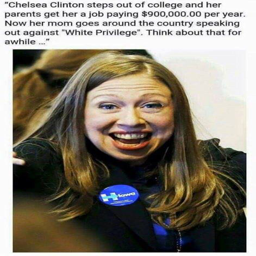

In [5]:
print('###################################################')
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)
print('###################################################')

#To observe the label text, we can decode the labels using the processor
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print('Decoded label text :', label_str)
print('###################################################')

image = Image.open(train_dataset.root_dir + train_df['image'][0]).convert("RGB")
# Make the image smaller to fit in the screen
image.resize((256, 256))



## **Train the model**

Here, we **initialize the TrOCR model with its pretrained weights**. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage.

In [6]:
# Initiate the model and processor
pre_model, processor = load_model_with_check()

Loaded model and processor from local storage


Importantly, we need to set a couple of attributes, namely:

`model.config.max_length = 32`
 - Memes typically have short text (rarely exceeding 30 words)

`model.config.early_stopping = True`
 - Stops generation early if the model predicts an end-of-sequence token `[SEP]`, preventng redundant text

.
.
.

`model.config.num_beams = 5`
 - **Beam search** is a decoding algorithm used in sequence generation tasks to find high quality output sequences by balancing **exploration** and **exploitation**. It improves upond greedy search (which picks the single best token at each step) by maintaining a fixed number of candidate sequences and selecting the most promising overall sequence.


In [7]:
# Apply configuration
model = configure_model(
    model=pre_model,
    processor=processor,
    max_length=32,
    num_beams=5,
    temperature=0.9
)

Next, we can define some **training hyperparameters** by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

#### **Steps per Epoch and Total Training Steps Calculation**

**Given Parameters**:
- **Dataset Size**: 10,000 samples  
- **Batch Size**: 32 samples per batch  
- **Number of Epochs**: 5  


1. **Steps per Epoch**  
Steps per epoch define how many batches are processed in one full pass over the dataset.  
**Formula**:  
$$
steps\_per\_epoch = dataset\_size // batch\_size
$$

In [8]:
training_args = Seq2SeqTrainingArguments(
    
    output_dir="./trocr-meme-model",
    evaluation_strategy="steps",
    
    # Device optimization
    fp16=cuda_available(),  # Only enable if CUDA is available
    
    # Adjusted steps for 3500 training samples
    per_device_train_batch_size=8 if cuda_available() else 2,
    per_device_eval_batch_size=8 if cuda_available() else 2,
    eval_steps=100,
    save_steps=200,
    
    # Training parameters
    learning_rate=3e-5,
    num_train_epochs=15,

    # Phase 1: (Learning rate warmup) increases linearly from 0 to 3e-5
    # Phase 2: (Learning rate decay) decreases linearly from 3e-5 to 0
    warmup_steps=50,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    
    
    # Generation & metrics
    predict_with_generate=True,
    generation_max_length=32,  # Match meme text length
    
    
    # Model saving
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    
    #No logging
    report_to="none"
    
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

#### **Math behind CER**
Character Error Rate (CER) is a common metric of the performance of an automatic speech recognition system

$$
CER = (S + D + I) / N = (S + D + I) / (S + D + C)
$$

where
 - $ S $ is the number of substitutions
 - $ D $ is the number of deletions
 - $ I $ is the number of insertions
 - $ C $ is the number of correct characters
 - $ N $ is the number of characters in reference

**Inference**: The lower the value, the better the performance of the ASR system (TrOCR in our case) with a CER of 0 being a perfect score.

**Remark**: This metric is highly dependent on the content and quality of the dataset, and therefore users can expect very different values for the same model but on different datasets


In [9]:
cer_metric = load_metric("cer")

C:\Users\Mert\AppData\Local\Temp\ipykernel_28192\4287149634.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
c:\Users\Mert\anaconda3\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The `compute_metrics()` function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a **dictionary**. The model will return an `EvalPrediction` at evaluation, which consists of 2 things:

 - **Predictions**: predictions by the model
 - **Label_ids**: actual ground-truth labels


#### **New metric (optional): BLEU (Bilingual Evaluation Understudy)**

It measures the similarity between a candidate text (e.g., machine-generated output) and one or more reference texts (human-generated ground truth)

BLEU compares overlapping n-grams between the candidate and reference texts

In [10]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [11]:
#Define Augmentations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(3,7), sigma=(0.1, 0.5))
])

#Create Augmented Datasets
train_dataset = AugmentedMMFHAR(
    root_dir='../data/processed/MMF_HAR_comb_processed/images/training/',
    df=train_df,
    processor=processor,
    transform=train_transform,
    max_target_length=32
)

eval_dataset = AugmentedMMFHAR(  # No augmentations for eval
    root_dir='../data/processed/MMF_HAR_comb_processed/images/testing/',
    df=test_df,
    processor=processor,
    transform=None, 
    max_target_length=32
)

#Get the lenght of the datasets
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3429
Number of validation examples: 858


#### **Collator function**

**Custom collator function** is used during training to **prepare (or so to say "collate") a batch of data** so that it can be efficiently fed into the model

In Pytorch, a collator function is responsible for taking a list of individual data items and combining them into a single batch. This involves converting data types, handling tensors, and stacking items along a new dimension so that each field appears as a **batch tensor**.

When we instantiate the `Seq2SeqTrainer`:
 - During each iteration, as the trainer fetches a batch from the dataset, it calls `augmented_collator` with that list of samples. The collator then converts and stacks the images and labels into batch tensors, which are finally fed into the model for training or evaluation

In [13]:
# Update Trainer with Custom Collator
def augmented_collator(batch):
    to_tensor = ToTensor()  # Create converter inside collator
    
    # Convert all images to tensors
    pixel_values = torch.stack([
        item["pixel_values"] if torch.is_tensor(item["pixel_values"]) 
        else to_tensor(item["pixel_values"]) 
        for item in batch
    ])
    
    labels = torch.stack([item["labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Instantiate Trainer with Augmentations
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=augmented_collator,  # Use custom collator
)

In [14]:
trainer.train()

  0%|          | 0/6420 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### **Possible Outcome**
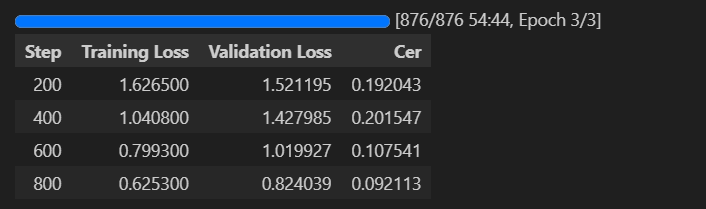 